In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import glob
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms

# EDA

The dataset consists of


In [3]:
from enum import Enum
import seaborn as sns
class DataType(Enum):
    TEST = "test"
    TRAIN = "train"


class CustomDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), datatype=DataType.TEST):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.datatype = datatype
        self.transform = self._get_transform(size)
        self.monet_idx = self._create_index(self.monet_dir)
        self.photo_idx = self._create_index(self.photo_dir)

    def _get_transform(self, size):
        transform_list = [transforms.Resize(size), transforms.ToTensor()]
        
        if self.datatype == DataType.TRAIN:
            transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        
        return transforms.Compose(transform_list)

    def _create_index(self, directory):
        return {i: fl for i, fl in enumerate(glob.glob(f"{directory}/*"))}

    def __getitem__(self, idx):
        rand_idx = np.random.randint(0, len(self.photo_idx))
        photo_img = self._load_image(self.photo_dir, self.photo_idx[rand_idx])
        monet_img = self._load_image(self.monet_dir, self.monet_idx[idx])
        return photo_img, monet_img

    def _load_image(self, dir_path, file_name):
        img_path = file_name  # Since glob already gives the full path
        image = Image.open(img_path)
        return self.transform(image)
    
    def __len__(self):
        return min(len(self.monet_idx), len(self.photo_idx))

In [4]:
DATA_PATH = "data/"
BATCH_SIZE = 32 # 4
EPOCHS = 10
# DATA_PATH = # "../input/gan-getting-started"
device = "cuda:0"

In [5]:
img_ds = CustomDataset(f'{DATA_PATH}/monet_jpg/', f'{DATA_PATH}/photo_jpg/', datatype=DataType.TRAIN)

In [6]:
sampler = SubsetRandomSampler(range(len(img_ds)))
img_dl = DataLoader(img_ds, batch_size=BATCH_SIZE,num_workers=20, sampler=sampler,drop_last=True)

In [7]:
photo_img, monet_img = next(iter(img_dl))

In [8]:

def unnorm(img, mean=None, std=None):
    if mean is None:
        mean = [0.5, 0.5, 0.5]
    if std is None:
        std = [0.5, 0.5, 0.5]
    
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

def display_image(subplot, title, img):
    plt.subplot(subplot)
    plt.title(title)
    img = unnorm(img)
    plt.imshow(img[0].permute(1, 2, 0))

def main(photo_img, monet_img):
    f = plt.figure(figsize=(8, 8))
    
    display_image(121, 'Real photo to style', photo_img)
    display_image(122, 'Monet picture', monet_img)
    
    plt.show()

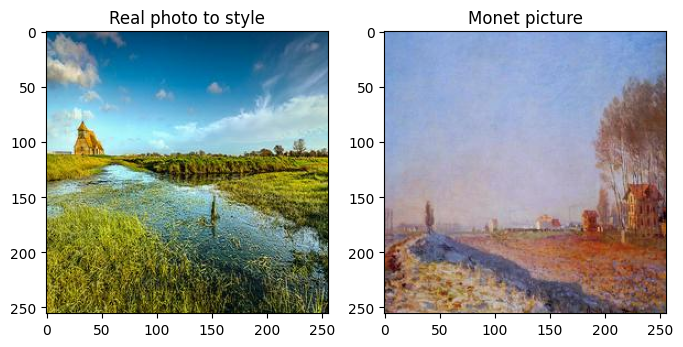

In [9]:
main(photo_img, monet_img)

# Save and Load

In [10]:
def save_state(state, save_path):
    torch.save(state, save_path)

# Model

In [11]:
import torch.nn as nn

class UpsampleModel(nn.Module):
    """A model for upsampling with optional dropout."""

    KERNEL_SIZE = 3
    STRIDE = 2
    PADDING = 1
    OUTPUT_PADDING = 1

    def __init__(self, input_channels: int, out_channels: int, use_dropout: bool = True, dropout_ratio: float = 0.5) -> None:
        super(UpsampleModel, self).__init__()
        
        layers = [
            nn.ConvTranspose2d(input_channels, out_channels, self.KERNEL_SIZE, 
                               stride=self.STRIDE, padding=self.PADDING, 
                               output_padding=self.OUTPUT_PADDING),
            nn.InstanceNorm2d(out_channels),
            nn.GELU()
        ]
        
        if use_dropout:
            layers.insert(2, nn.Dropout(dropout_ratio))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [12]:
def Convlayer(input_channels, out_channels, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(input_channels, out_channels, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(input_channels, out_channels, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_channels)
    else:
        norm = nn.BatchNorm2d(out_channels)

    return nn.Sequential(
        conv,
        norm,
        actv
    )

In [13]:
class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

In [14]:
class Generator(nn.Module):
    def __init__(self, input_channels, out_channels, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(input_channels, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(UpsampleModel(256, 128))
        model.append(UpsampleModel(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_channels, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(input_channels, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            input_channelss = 64 * 2**(i-1)
            out_channelss = input_channelss * 2
            if i == num_layers -1:
                model.append(Convlayer(input_channelss, out_channelss, 4, 1))
            else:
                model.append(Convlayer(input_channelss, out_channelss, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [16]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

# Some additional classes and functions

In [17]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [18]:

class SampleFake():
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

class AvgStats():
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

class LRSched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

# GANCycle

In [21]:
class GANCycle():
    def __init__(self, input_channels, out_channels, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = max(decay_epoch, int(epochs / 2))
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        
        self._initialize_models(input_channels, out_channels)
        self._initialize_loss_functions()
        self._initialize_optimizers(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()), 
                                    itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()), 
                                    start_lr)
        self._initialize_schedulers(self.adam_gen, self.adam_desc, self.decay_epoch, epochs)
        self._initialize_statistics()
        self._initialize_fake_samples()

    def _initialize_models(self, input_channels, out_channels):
        self.gen_mtp = self._init_model(Generator(input_channels, out_channels))
        self.gen_ptm = self._init_model(Generator(input_channels, out_channels))
        self.desc_m = self._init_model(Discriminator(input_channels))
        self.desc_p = self._init_model(Discriminator(input_channels))

    def _init_model(self, model):
        init_weights(model)
        return model.to(self.device)

    def _initialize_loss_functions(self):
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def _initialize_optimizers(self, gen_params, desc_params, start_lr):
        self.adam_gen = torch.optim.Adam(gen_params, lr=start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(desc_params, lr=start_lr, betas=(0.5, 0.999))

    def _initialize_schedulers(self, adam_gen, adam_desc, decay_epoch, epochs):
        gen_lr = lr_sched(decay_epoch, epochs)
        desc_lr = lr_sched(decay_epoch, epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(adam_desc, desc_lr.step)

    def _initialize_statistics(self):
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()

    def _initialize_fake_samples(self):
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss, avg_desc_loss = 0.0, 0.0
            total_samples = len(photo_dl)
            
            t = tqdm(photo_dl, leave=False, total=total_samples)
            for photo_real, monet_real in t:
                photo_img, monet_img = photo_real.to(self.device), monet_real.to(self.device)
                
                self._train_generators(photo_img, monet_img)
                avg_gen_loss += self.total_gen_loss.item()

                self._train_discriminators(photo_img, monet_img)
                avg_desc_loss += self.total_desc_loss.item()
                
                t.set_postfix(gen_loss=self.total_gen_loss.item(), desc_loss=self.total_desc_loss.item())

            self._save_model(epoch)
            self._update_statistics(epoch, avg_gen_loss, avg_desc_loss, total_samples, start_time)

    def _train_generators(self, photo_img, monet_img):
        self._set_requires_grad([self.desc_m, self.desc_p], False)
        self.adam_gen.zero_grad()

        fake_photo, fake_monet = self.gen_mtp(monet_img), self.gen_ptm(photo_img)
        cycl_monet, cycl_photo = self.gen_ptm(fake_photo), self.gen_mtp(fake_monet)
        id_monet, id_photo = self.gen_ptm(monet_img), self.gen_mtp(photo_img)

        idt_loss_monet = self._identity_loss(id_monet, monet_img)
        idt_loss_photo = self._identity_loss(id_photo, photo_img)
        cycle_loss_monet = self._cycle_loss(cycl_monet, monet_img)
        cycle_loss_photo = self._cycle_loss(cycl_photo, photo_img)
        adv_loss_monet = self._adversarial_loss(self.desc_m(fake_monet), True)
        adv_loss_photo = self._adversarial_loss(self.desc_p(fake_photo), True)

        self.total_gen_loss = (idt_loss_monet + idt_loss_photo + cycle_loss_monet + 
                               cycle_loss_photo + adv_loss_monet + adv_loss_photo)

        self.total_gen_loss.backward()
        self.adam_gen.step()

    def _train_discriminators(self, photo_img, monet_img):
        self._set_requires_grad([self.desc_m, self.desc_p], True)
        self.adam_desc.zero_grad()

        with torch.no_grad():
            fake_monet = self._sample_fake(self.gen_ptm(photo_img))
            fake_photo = self._sample_fake(self.gen_mtp(monet_img))

        monet_desc_real = self.desc_m(monet_img)
        monet_desc_fake = self.desc_m(fake_monet)
        photo_desc_real = self.desc_p(photo_img)
        photo_desc_fake = self.desc_p(fake_photo)

        monet_desc_loss = self._discriminator_loss(monet_desc_real, monet_desc_fake)
        photo_desc_loss = self._discriminator_loss(photo_desc_real, photo_desc_fake)

        self.total_desc_loss = monet_desc_loss + photo_desc_loss

        self.total_desc_loss.backward()
        self.adam_desc.step()

    def _identity_loss(self, id_img, target_img):
        return self.l1_loss(id_img, target_img) * self.lmbda * self.idt_coef

    def _cycle_loss(self, cycl_img, target_img):
        return self.l1_loss(cycl_img, target_img) * self.lmbda

    def _adversarial_loss(self, pred, is_real):
        real_target = torch.ones_like(pred).to(self.device) if is_real else torch.zeros_like(pred).to(self.device)
        return self.mse_loss(pred, real_target)

    def _discriminator_loss(self, real_pred, fake_pred):
        real_loss = self.mse_loss(real_pred, torch.ones_like(real_pred).to(self.device))
        fake_loss = self.mse_loss(fake_pred, torch.zeros_like(fake_pred).to(self.device))
        return (real_loss + fake_loss) / 2

    def _sample_fake(self, fake_tensor):
        fake_sample = fake_tensor.cpu().data.numpy()
        fake_sample = torch.tensor(self.sample_monet([fake_sample])[0]).to(self.device)
        return fake_sample

    def _set_requires_grad(self, nets, requires_grad):
        for net in nets:
            for param in net.parameters():
                param.requires_grad = requires_grad

    def _save_model(self, epoch):
        save_dict = {
            'epoch': epoch+1,
            'gen_mtp': self.gen_mtp.state_dict(),
            'gen_ptm': self.gen_ptm.state_dict(),
            'desc_m': self.desc_m.state_dict(),
            'desc_p': self.desc_p.state_dict(),
            'optimizer_gen': self.adam_gen.state_dict(),
            'optimizer_desc': self.adam_desc.state_dict()
        }
        save_state(save_dict, 'model.pt')

    def _update_statistics(self, epoch, avg_gen_loss, avg_desc_loss, total_samples, start_time):
        avg_gen_loss /= total_samples
        avg_desc_loss /= total_samples
        time_req = time.time() - start_time
        
        self.gen_stats.append(avg_gen_loss, time_req)
        self.desc_stats.append(avg_desc_loss, time_req)
        
        print(f"Epoch: {epoch+1} | Generator Loss: {avg_gen_loss:.6f} | Discriminator Loss: {avg_desc_loss:.6f}")
        self.gen_lr_sched.step()
        self.desc_lr_sched.step()

In [33]:
EPOCHS = 10

In [34]:
gan = GANCycle(3, 3, EPOCHS, device)

In [35]:
# Save before train
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.desc_m.state_dict(),
    'desc_p': gan.desc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_desc.state_dict()
}

In [36]:
save_state(save_dict, 'init.pt')

In [37]:
gan.train(img_dl)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | Generator Loss: 19.177317 | Discriminator Loss: 4.139967


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2 | Generator Loss: 14.684225 | Discriminator Loss: 2.180822


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3 | Generator Loss: 11.600112 | Discriminator Loss: 1.093355


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4 | Generator Loss: 11.106516 | Discriminator Loss: 0.947507


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5 | Generator Loss: 13.566050 | Discriminator Loss: 2.654962


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6 | Generator Loss: 10.174143 | Discriminator Loss: 0.795855


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7 | Generator Loss: 9.975468 | Discriminator Loss: 0.619985


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8 | Generator Loss: 9.502929 | Discriminator Loss: 0.564007


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9 | Generator Loss: 9.323833 | Discriminator Loss: 0.564109


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10 | Generator Loss: 9.049015 | Discriminator Loss: 0.528037


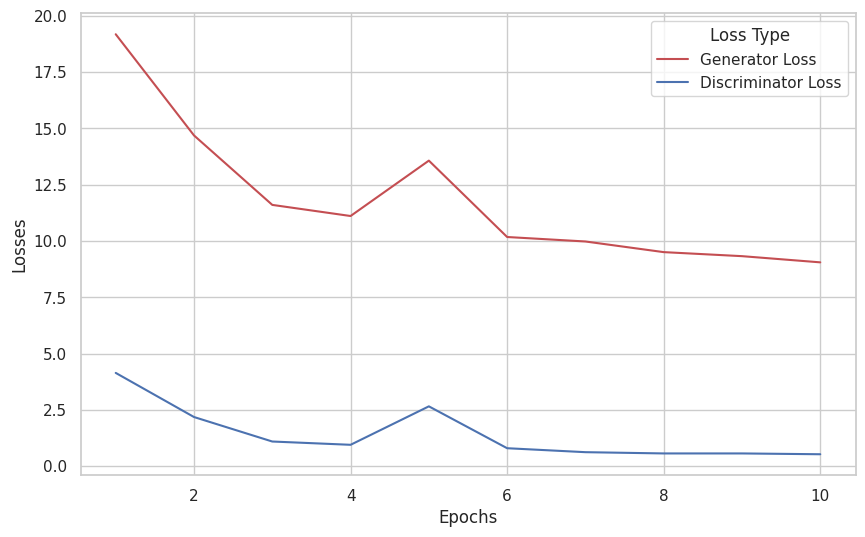

In [38]:
gen_losses = gan.gen_stats.losses
disc_losses = gan.desc_stats.losses
epochs = list(range(1, len(gen_losses) + 1))


df = pd.DataFrame({
    'Epoch': epochs,
    'Generator Loss': gen_losses,
    'Discriminator Loss': disc_losses
})

sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='value', hue='variable', 
             data=pd.melt(df, ['Epoch']), palette={'Generator Loss': 'r', 'Discriminator Loss': 'b'})


plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(title='Loss Type')
plt.show()

In [39]:
img_dl = DataLoader(img_ds, batch_size=BATCH_SIZE,num_workers=5, sampler=sampler,drop_last=True)

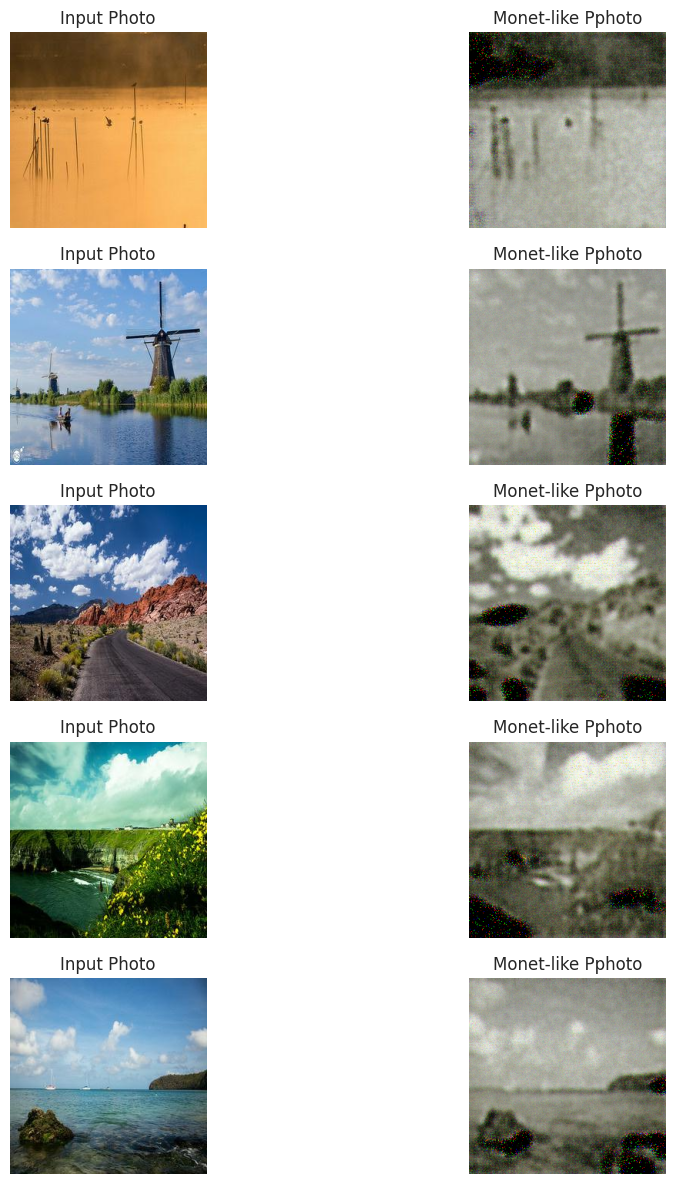

In [45]:
def present_results():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i in range(5):
        photo_img, _ = next(iter(img_dl))
        pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
        photo_img = unnorm(photo_img)
        pred_monet = unnorm(pred_monet)
        
        ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
        ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-like Pphoto")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

present_results()

In [42]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img

    def __len__(self):
        return len(self.photo_idx.keys())

ph_ds = PhotoDataset(f'{DATA_PATH}/photo_jpg/')

ph_dl = DataLoader(ph_ds, batch_size=128, pin_memory=True, num_workers=64)


trans = transforms.ToPILImage()

t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = unnorm(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    img.save("images/" + str(i+1) + ".jpg")

shutil.make_archive("images", 'zip', "images")

  0%|          | 0/55 [00:00<?, ?it/s]

'/workspace/gan-monet-boulder/images.zip'

In [43]:
shutil.make_archive("/kaggle/working/images", 'zip', "images")

'/kaggle/working/images.zip'

# Sources
1. https://www.kaggle.com/code/nachiket273/cyclegan-pytorch
2. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
3. https://www.kaggle.com/code/ohseokkim/transfering-style
4. https://junyanz.github.io/CycleGAN/